In [1]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import mdtraj as md
import pyemma

import extq
import ivac

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
# cv_trajs.extend(
#     np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
# )
# cv_trajs.extend(
#     np.load("../../data/raw_feat/cv_dist_spin_suppl_01.npy", allow_pickle=True)
# )
# cv_trajs.extend(
#     np.load("../../data/raw_feat/cv_dist_spin_suppl_02.npy", allow_pickle=True)
# )
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
# for i in range(6):
#     sb_trajs.extend(
#         np.load(f"../../data/raw_feat/feat2_suppl_{i:02d}.npy", allow_pickle=True)
#     )
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3170017, 2) (3170017, 60)


# 

In [8]:
# all sidechain torsions for arginines
arg_tors = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
for r in (217, 223, 226, 229, 232):
    arg_tors.add_sidechain_torsions(f"residue {r}", deg=False, which="all")
arg_tors.describe()

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


['CHI1 0 ARG 217',
 'CHI2 0 ARG 217',
 'CHI3 0 ARG 217',
 'CHI4 0 ARG 217',
 'CHI5 0 ARG 217',
 'CHI1 0 ARG 223',
 'CHI2 0 ARG 223',
 'CHI3 0 ARG 223',
 'CHI4 0 ARG 223',
 'CHI5 0 ARG 223',
 'CHI1 0 ARG 226',
 'CHI2 0 ARG 226',
 'CHI3 0 ARG 226',
 'CHI4 0 ARG 226',
 'CHI5 0 ARG 226',
 'CHI1 0 ARG 229',
 'CHI2 0 ARG 229',
 'CHI3 0 ARG 229',
 'CHI4 0 ARG 229',
 'CHI5 0 ARG 229',
 'CHI1 0 ARG 232',
 'CHI2 0 ARG 232',
 'CHI3 0 ARG 232',
 'CHI4 0 ARG 232',
 'CHI5 0 ARG 232']

In [9]:
xtc_files = []
for i in range(3, 20):
    xtc_files.append(f"/project2/roux/scguo/ci-vsd/anton2/prot/civsd.prot.{i}.xtc")

In [10]:
arg_tors_anton2 = pyemma.coordinates.load(xtc_files, features=arg_tors, chunksize=64)

Obtaining file info:   0%|          | 0/17 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/2669 [00:00<?, ?it/s]

In [11]:
np.save("../../data/raw_feat/arg_torsions_anton2.npy", arg_tors_anton2)

In [12]:
arg_tors_trajs = np.load("../../data/raw_feat/arg_torsions.npy", allow_pickle=True)

## Compute S4 sidechain rotamers

In [10]:
# all sidechain torsions for arginines
s4_tors = pyemma.coordinates.featurizer("../../civsd-pro.pdb")

In [17]:
s4_tors.add_sidechain_torsions(cossin=True, which="all")
print(len(s4_tors.describe()))

18-01-22 15:41:26 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  tried to re-add the same feature SideChainTorsions
496


/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


In [25]:
# all sidechain torsions for arginines
sidechain_tors = pyemma.coordinates.featurizer("../../civsd-pro.pdb")

In [26]:
sidechain_tors.add_sidechain_torsions(cossin=True, which="all")

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


In [27]:
print(len(sidechain_tors.describe()))

496


In [28]:
remove = {
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
xtcs = []
for i in range(1000, 1295):
    if i not in remove:
        xtcs.append(f"../../anton/xtccombined/civsd_{i}.xtc")
xtc_files = np.loadtxt("../../data/suppl_xtc_files.txt", dtype=str)

In [29]:
len(xtcs), len(xtc_files)

(237, 244)

In [20]:
# s4_tors_trajs = pyemma.coordinates.load(xtcs, features=s4_tors, chunksize=64)
# np.save("../../data/raw_feat/sidechain_tors_anton", s4_tors_trajs)

100%|██████████| 47051/47051 [14:39<00:00, 53.47it/s]                                 
/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [34]:
sidechain_dihed_trajs = pyemma.coordinates.load(
    xtcs, features=sidechain_tors, chunksize=64
)
np.save("../../data/raw_feat/sidechain_tors_anton", sidechain_dihed_trajs)

100%|██████████| 47051/47051 [12:48<00:00, 61.19it/s]                                 
/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
sidechain_dihed_trajs = np.load(
    "../../data/raw_feat/sidechain_tors_anton.npy", allow_pickle=True
)
print(sidechain_dihed_trajs.shape, sidechain_dihed_trajs[0].shape)

(237,) (10000, 496)


In [15]:
# s4_tors_trajs_suppl = pyemma.coordinates.load(xtc_files, features=s4_tors, chunksize=64)
# np.save("../../data/raw_feat/sidechain_tors_suppl", s4_tors_trajs_supppl)

# IVAC

In [12]:
livac = ivac.LinearIVAC(minlag=1, maxlag=10000, nevecs=10, addones=False, adjust=True)
livac.fit(sidechain_dihed_trajs)
ivac_tors_trajs = livac.transform(sidechain_dihed_trajs)

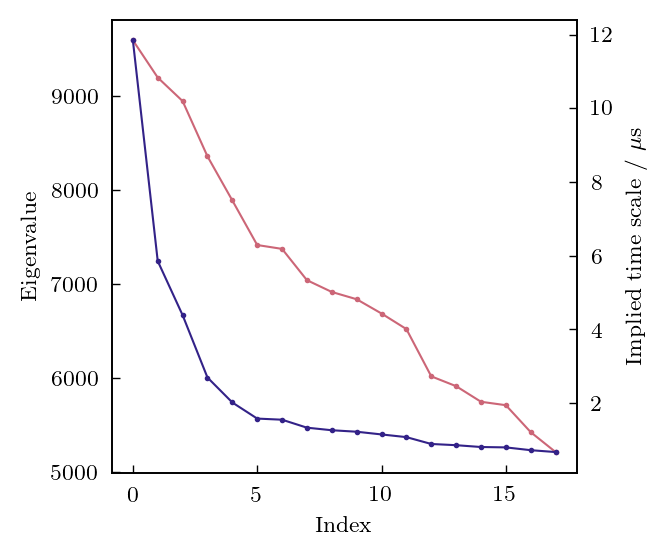

In [13]:
# plot eigenvalues and implied time scales
f = plt.figure(dpi=200)
ax = plt.gca()
ax.plot(livac.evals[2:20], ".-", color="C0")
ax.set_xlabel("Index")
ax.set_ylabel("Eigenvalue")

ax2 = ax.twinx()
ax2.plot(livac.its[2:20] * 0.0001, ".-", color="C1")
ax2.set_ylabel("Implied time scale / $\mu$s")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

In [14]:
np.save("../../data/raw_feat/ivac_sidechain_tors", ivac_tors_trajs)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


# Clustering